In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import re
import string
from unidecode import unidecode
import emoji

# import torchtext.vocab
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Test

In [6]:
file_test = 'test_spam.csv'

data_test = pd.read_csv(file_test)
data_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [4]:
data_test.shape

(4070, 1)

In [7]:
data_test.iloc[0, 0]

'j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso'

### Train

In [9]:
file_train = 'train_spam.csv'

data_train = pd.read_csv(file_train)
data_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [10]:
data_train.shape

(16278, 2)

In [12]:
data_train.iloc[0, 1]

'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned'

## Базовая аналитика

In [17]:
number_of_ham = sum(data_train['text_type'] == 'ham')
number_of_spam = sum(data_train['text_type'] == 'spam')

print(f"Число нормальных сообщений: {number_of_ham}")
print(f"Число спама: {number_of_spam}")

Число нормальных сообщений: 11469
Число спама: 4809


In [18]:
print(f'Точность константного классификатора {number_of_ham/(number_of_ham + number_of_spam):.3f}')

Точность константного классификатора 0.705


In [19]:
data_ham = data_train[data_train['text_type'] == 'ham']
data_spam = data_train[data_train['text_type'] == 'spam']

In [24]:
texts_ham = data_ham['text'].to_list()

In [25]:
texts_ham[-20:]

['any of your writing online anywhere would love to take a look i was plagued with night terrors for years and tried to capture that feeling after waking up if you want to call that waking up but was never able to cindy on mon 1635465 sep 1635465 eirikur hallgrimsson wrote on monday 1635465 september 1635465 1635465 1635465 pm geege schuman wrote ever notice how the feelings evoked in some dreams stick with you all day i m sure it s some neurochemical process initiated during the dream that is still cycling thru like a deja vu triggered by memory processes where you don t actually remember but you feel like you re remembering absolutely and i ve wanted to recapture it i ve done some writing based on dreams and there is a mysterious mood to that feeling that drives some creative stuff for me',
 'url url date 1635465 1635465 1635465t1635465 1635465 1635465 1635465 1635465 with project budgets in the multiple millions of dollars and virtually no margin for error more and more development 

In [26]:
texts_spam = data_spam['text'].to_list()
texts_spam[-40:]

['still paying too much for life insurance u save up to 75 on your term life insurance compare rates from top insurance companies around the country in our life and times it s important to plan for your family s future while being comfortable financially choose the right life insurance policy today click the link below to compare the lowest rates and save up to 75 compare your coverage you ll be able to compare rates and get a free application in less than a minute get your free instant quotes compare the lowest prices then select a company and apply online get a free quote now you can t predict the future but you can always prepare for it to be excluded from future contacts kanz http xent com mailman listinfo fork',
 'ɪ ɪɴᴠᴇꜱᴛᴇᴅ $300 ᴅᴏʟʟᴀʀꜱ ᴀɴᴅ ʀᴇᴄᴇɪᴠᴇ $3000 ᴅᴏʟʟᴀʀꜱ ᴛᴏᴅᴀʏ ꜰʀᴏᴍ ᴛʜɪꜱ ʙɪɴᴀʀʏ ᴘʟᴀᴛꜰᴏʀᴍ ᴛʜɪꜱbᴄᴏᴍᴘᴀɴʏ ɪꜱ ᴛʀᴜꜱᴛᴇᴅ ɪɴᴠᴇꜱᴛ ᴡɪᴛʜ ᴛʜᴇᴍ ᴀɴᴅ ꜰᴏʀɢᴇᴛ ᴀʙᴏᴜᴛ ᴅᴏᴇꜱ ꜰᴀᴋᴇ ᴄᴏᴍᴘᴀɴɪᴇꜱ 🇺🇸🇩🇪🇪🇦🇨🇳🇨🇭🇫🇰🇬🇧🇨🇵🇨🇮🇨🇺🇧🇷🇧🇪 👇👇👇👇👇 @fxshawnjsinek01 @joinchat2ptgu5bdx1tlogm0 @joinchat2ptgu5bdx1tlogm0 @joinchat2p

### Распределение длин сообщений в символах


Ham min max 1 800
Spam min max 5 800


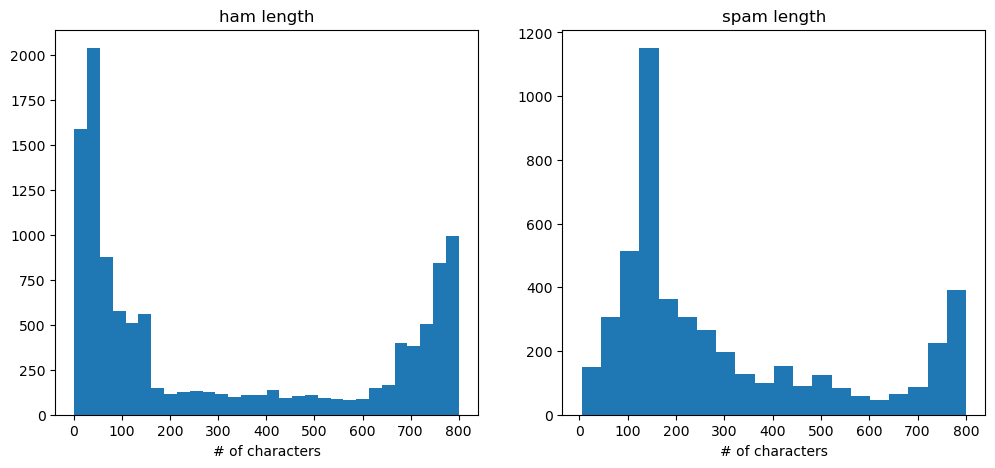

In [39]:
ham_len = list(map(len, list(texts_ham)))
spam_len = list(map(len, list(texts_spam)))
print('Ham min max', np.min(ham_len), np.max(ham_len))
print('Spam min max', np.min(spam_len), np.max(spam_len))


plt.figure(figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.title("ham length")
plt.hist(ham_len, bins=30)
plt.xlabel('# of characters')

plt.subplot(1, 2, 2)
plt.title("spam length")
plt.hist(spam_len, bins=20)
plt.xlabel('# of characters')

plt.show()

### Переводим в токены

In [40]:
lemmatizer = WordNetLemmatizer()

tokenizer = TweetTokenizer()

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

In [55]:
def remove_hyperlink(words):
    return  re.sub(r"http\S+", "", words)

def to_lower(words):
    result = words.lower()
    return result


def remove_underscore(words):
    return re.sub(r'_', ' ', words)

def remove_punctuation(words):
    result = re.sub(r'[!"#%&\'()*+,-./:;<=>?@\[\]^`{|}~]', ' ', words) # everything except underscore
    return result


def emoji_to_text(words):
    return emoji.demojize(words)

def replace_emoji(words,  replace=' <EMOJI> '):
    return emoji.replace_emoji(words, replace=replace)

def remove_emoji(words):
    return replace_emoji(words, '')


def replace_non_ascii(words, replace=' <NONASCII> '):
    pattern = r'\b[^\x00-\x7F]+\b'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words


def replace_number(words, replace=' <NUMBER> '):
    result = re.sub(r'\b\w*\d\w*\b', replace, words)
    return result

def remove_number(words):
    return replace_number(words, '')


def replace_currency(words, replace=' <CURRENCY> '):
    currency_pattern = r'[£$€₹]'
    return re.sub(currency_pattern, replace, words)

def remove_currency(words):
    return replace_currency(words, '')


def remove_whitespace(words):
    return words.strip()

def replace_newline(words):
    return words.replace('\n', '')

def remove_stop_words(words):
    return [i for i in words if i not in ENGLISH_STOP_WORDS]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(s) for s in words]

In [56]:
def preprocess_pipeline(sentence, preprocess_utils=None):
    if preprocess_utils is None:
        preprocess_utils = [
                            remove_hyperlink,
                            replace_newline,
                            to_lower,
                            remove_underscore,
                            replace_emoji,
                            replace_non_ascii,
                            replace_number,
                            replace_currency,
                            remove_punctuation,
                            remove_whitespace,
                            tokenizer.tokenize,
                            remove_stop_words,
                            word_lemmatizer,
                        ]
    for func in preprocess_utils:
        sentence = func(sentence)
    return sentence

In [57]:
texts_ham_tokenized = [
    preprocess_pipeline(sent) for sent in texts_ham
]

texts_spam_tokenized = [
    preprocess_pipeline(sent) for sent in texts_spam
]

Ham min max 0 148
Spam min max 1 238


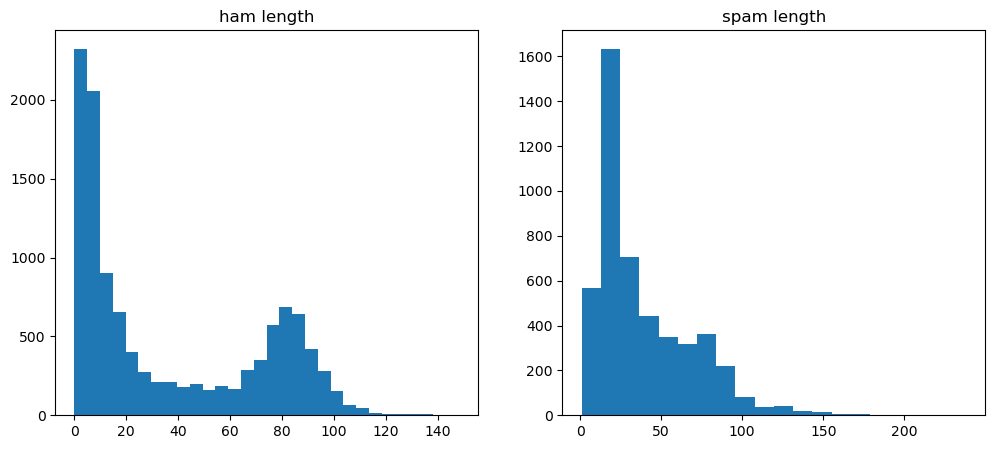

In [44]:
ham_len = list(map(len, texts_ham_tokenized))
spam_len = list(map(len, texts_spam_tokenized))
print('Ham min max', np.min(ham_len), np.max(ham_len))
print('Spam min max', np.min(spam_len), np.max(spam_len))


plt.figure(figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.title("ham length")
plt.hist(ham_len, bins=30)

plt.subplot(1, 2, 2)
plt.title("spam length")
plt.hist(spam_len, bins=20)

plt.show()

## Word cloud plots

In [52]:
def plot_wordcloud(tokenized_text, mask=None, max_words=200, max_font_size=100, figure_size=(15, 10),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    
    text_strings = [' '.join(s) for s in tokenized_text]
    text = ' '.join(text_strings)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Уберем все числа, знаки валют, эмоджи. Приведем к ASCII нестандартные символы. Это нужно, чтобы эти keywords не забивали другие слова.

In [58]:
preprocess_utils = [
                    remove_hyperlink,
                    replace_newline,
                    to_lower,
                    remove_underscore,
                    remove_emoji,
                    unidecode,
                    remove_number,
                    remove_currency,
                    remove_punctuation,
                    remove_whitespace,
                    tokenizer.tokenize,
                    remove_stop_words,
                    word_lemmatizer,
                ]


texts_ham_tokenized_2 = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_ham
]

texts_spam_tokenized_2 = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_spam
]

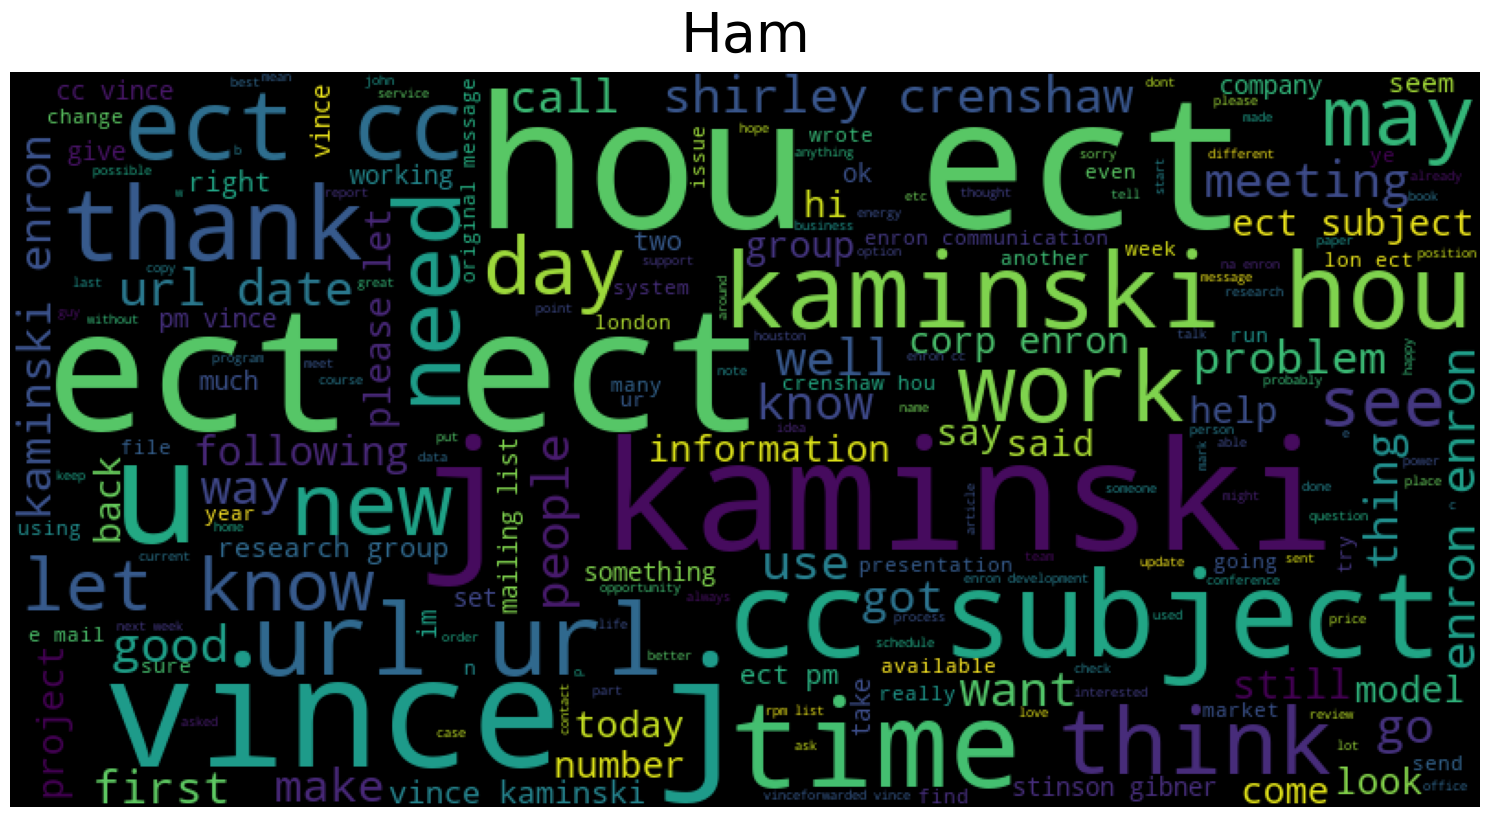

In [59]:
plot_wordcloud(texts_ham_tokenized_2, title='Ham')

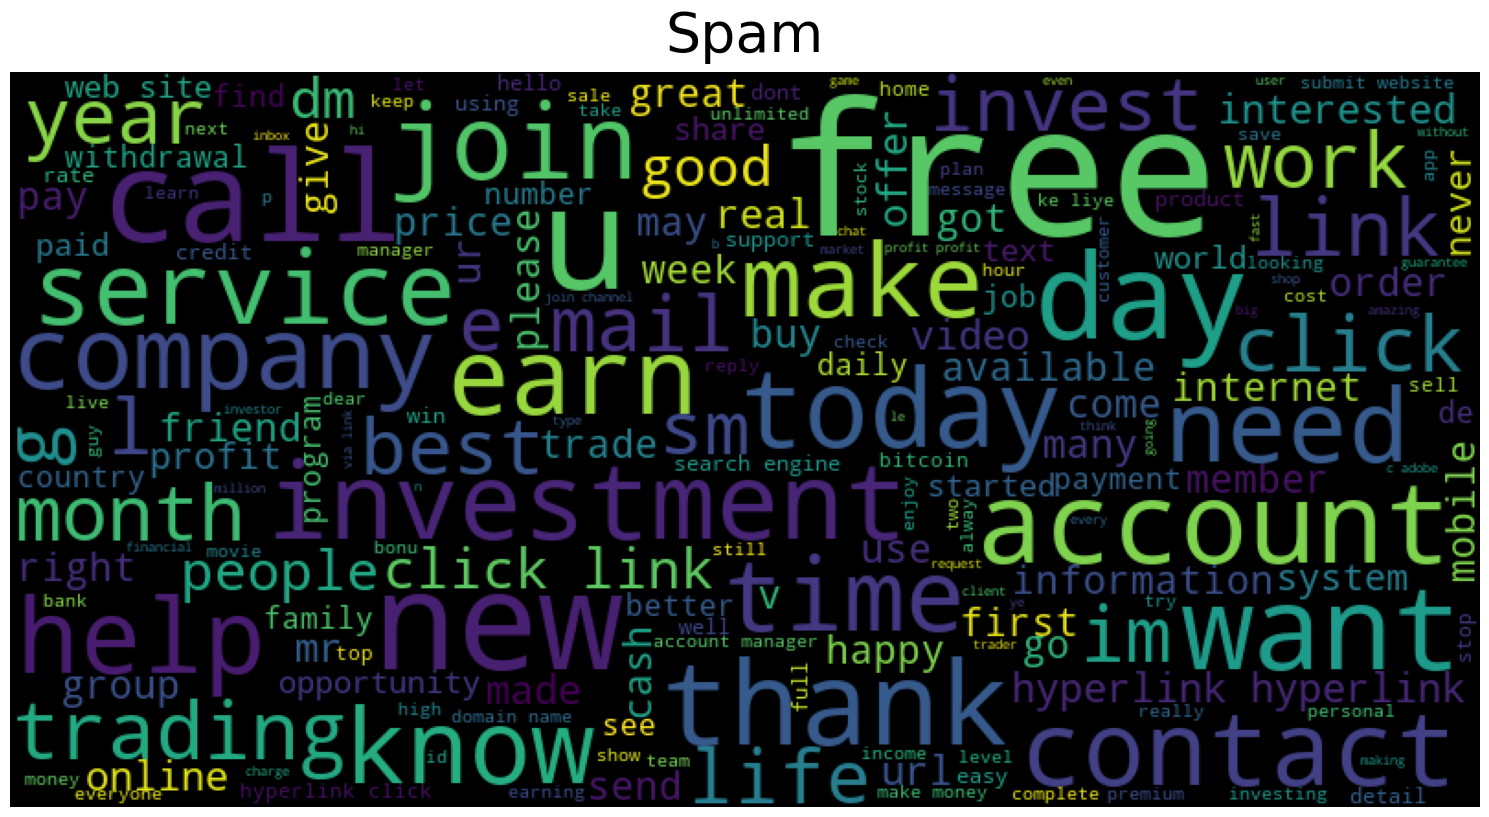

In [60]:
plot_wordcloud(texts_spam_tokenized_2, title='Spam')

## Построим словари и выведем наиболее частые слова

In [63]:
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    return counter

In [72]:
ham_vocab = build_vocab(texts_ham_tokenized)
print(f'Len of ham vocab {len(ham_vocab)}')

spam_vocab = build_vocab(texts_spam_tokenized)
print(f'Len of spam vocab {len(spam_vocab)}')

Len of ham vocab 28507
Len of spam vocab 18183


In [70]:
top_n = 25

top_ham_words = ham_vocab.most_common(top_n)

for word, count in top_ham_words:
    print(f"{word}: {count} {count/number_of_ham:.4f}")

NUMBER: 42804 3.7321
ect: 5344 0.4660
enron: 4848 0.4227
vince: 4525 0.3945
url: 3624 0.3160
hou: 2660 0.2319
kaminski: 2365 0.2062
subject: 2114 0.1843
u: 2110 0.1840
j: 1931 0.1684
cc: 1909 0.1664
please: 1888 0.1646
com: 1852 0.1615
would: 1850 0.1613
pm: 1821 0.1588
time: 1569 0.1368
like: 1440 0.1256
get: 1417 0.1236
thanks: 1407 0.1227
know: 1389 0.1211
group: 1220 0.1064
message: 1198 0.1045
one: 1165 0.1016
list: 1079 0.0941
new: 1012 0.0882


In [71]:
top_spam_words = spam_vocab.most_common(top_n)

for word, count in top_spam_words:
    print(f"{word}: {count} {count/number_of_spam:.4f}")

NUMBER: 18441 3.8347
NONASCII: 18190 3.7825
EMOJI: 11632 2.4188
CURRENCY: 1282 0.2666
free: 1087 0.2260
get: 882 0.1834
u: 602 0.1252
call: 581 0.1208
new: 570 0.1185
r: 565 0.1175
click: 557 0.1158
link: 544 0.1131
account: 507 0.1054
one: 499 0.1038
offer: 487 0.1013
company: 481 0.1000
money: 481 0.1000
com: 479 0.0996
time: 474 0.0986
please: 470 0.0977
day: 461 0.0959
business: 441 0.0917
want: 440 0.0915
make: 430 0.0894
best: 428 0.0890


## Testing

In [180]:
print(remove_punctuation("Hello 😀🌍🚀 World! 🌟👋"))

Hello     World    


In [29]:
ord('@')

64

In [30]:
s = 'abc df ghj k'
s.split()

['abc', 'df', 'ghj', 'k']

In [41]:
for i in range(500):
    text = texts_ham[i]
    for j in range(len(text)):
        if ord(text[j]) > 127:
            print(f'{i},{j}:', s, ord(text[j]))
            print(text)
            print()


41,12: l 146
fine if thats the way u feel thats the way its gota b

41,34: l 146
fine if thats the way u feel thats the way its gota b

109,16: l 8217
whatthecommitcom’s server ip address could not be found

114,6: l 252
i thk ü gotta go home by urself cos ill b going out shopping 4 my frens present

133,265: l 8211
the domestic dog canis familiaris or canis lupus familiaris is a domesticated descendant of the wolf the dog derived from an ancient extinct wolf and the modern grey wolf is the dogs nearest living relative the dog was the first species to be domesticated by hunter–gatherers over 15000 years ago before the development of agriculture their long association with humans has led dogs to be uniquely adapted to human behavior leading to a large number of domestic individuals and the ability to thrive on a starchrich diet that would be inadequate for other canidsthe dog has been selectively bred over millennia for various behaviors sensory capabilities and physical attributes 

In [80]:
import re

def extract_special_characters(text):
    # Define a regex pattern to match emojis and other special characters
    # pattern = r'[@#!\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U0001F1E0-\U0001F1FF\U0001D400-\U0001D7FF]'
    pattern = r'[@#!\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U0001F1E0-\U0001F1FF\U0001D400-\U0001D7FF\u00C0-\u00FF\u0100-\u017F\u0900-\u097F]'
    # Use findall to extract all matches
    special_characters = re.findall(pattern, text)
    return special_characters

# Example usage:
text = "Hello 😀🌍🚀 World! 🌟👋"
special_chars = extract_special_characters(text)
print("Special characters:", special_chars)

Special characters: ['😀', '🌍', '🚀', '!', '🌟', '👋']


In [178]:
def extract_emojis(text):
    pattern = r'[\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff]]'
    special_characters = re.findall(pattern, text, flags=re.UNICODE)
    return special_characters

In [179]:
print(extract_emojis("Hello 😀🌍🚀 World! 🌟👋"))

[]


In [84]:
print(extract_special_characters('whatthecommitcom’s server ip address could not be found'))

[]


In [177]:
emoji.UNICODE_EMOJI['en']

AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'

In [86]:
print(ord("'"))

39


In [78]:
for i in range(4000):
    text = texts_spam[i]
    specials = extract_special_characters(text)
    if specials != []:
        print(i, specials)
        print(text)
        print()


0 ['😊', '😊', '😊', '😊', '😁']
plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect and ads😊😊😊😊😁

9 ['👇', '👇', '👇', '👇', '👇', '👇', '👇', '👇', '👇']
after i lost my job i taught life has come to an end not knowing that god has a better plans for me binary options trade has been of good help to me and my family i invested with mr roberto robinson just immediately after i lost my job and today i am far richer than what i used to earn when i was still working under my former company now i know i have been wasting years just working myself so hard to a job there when i can make quick money with just little investment funds contact mr roberto robinson today and start earning massively via link below👇👇👇👇👇👇👇👇👇

11 ['𝑰', '𝒕', '𝒔', '𝒕', '𝒉', '𝒆', '𝒔', '𝒆', '𝒄', '𝒐', '𝒏', '𝒅', '𝒕', '𝒊', '𝒎', '𝒆', '𝒐', '𝒇', '𝒓', '𝒆', '𝒄', '𝒆', '𝒊', '𝒗', '𝒊', '𝒏', '𝒈', '𝒎', '𝒚', '𝒑', '𝒓', '𝒐', '𝒇', '𝒊', '𝒕', '𝒇', '𝒓', '𝒐', '𝒎', '𝒕', '𝒉', '𝒊', '𝒔', '𝒊', '𝒏', '𝒗

In [ ]:
when will the feg price rise？

Testing number removal

In [115]:

def replace_currency_symbols(text, currency_keyword=' CURRENCY '):
    # Define a regular expression pattern to match currency symbols
    currency_pattern = r'[£$€₹]'  # Add more currency symbols as needed
    
    # Use re.sub() to replace currency symbols with the keyword
    replaced_text = re.sub(currency_pattern, currency_keyword, text)
    
    return replaced_text

In [121]:
def replace_numbers_with_keyword(text, keyword=' NUMBER '):
    # Define a regex pattern to match numbers
    pattern = r'\b\w*\d\w*\b'
    # Replace all numbers in the text with the specified keyword
    replaced_text = re.sub(pattern, keyword, text)
    return replaced_text

In [124]:
text = '𝗚𝗠𝗔𝗜𝗟 google ads may requirements pakibasa muna — 𝟭𝟬𝟬𝟬 per running ads ๑ active gmail 6 months old up 99 primary ๑ no need access'

In [125]:
text = replace_currency_symbols(text)
text = replace_numbers_with_keyword(text)
print(text)

𝗚𝗠𝗔𝗜𝗟 google ads may requirements pakibasa muna —  NUMBER  per running ads  NUMBER  active gmail  NUMBER  months old up  NUMBER  primary  NUMBER  no need access


In [127]:
'𝗚𝗠𝗔𝗜𝗟'.lower()

'𝗚𝗠𝗔𝗜𝗟'